In [ ]:
# Tratamiento de datos
# ------------------------------------------------------------------------------
import numpy as np
import pandas as pd
from numpy import absolute
# Gráficos
# ------------------------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns

# Modelado y evaluación
# ------------------------------------------------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor 
import xgboost as xg
from xgboost import XGBRegressor
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import cross_val_score

from scipy import stats
from numpy import median
from statsmodels.graphics.gofplots import qqplot

from sklearn import model_selection
from sklearn.metrics import mean_squared_log_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, HuberRegressor, ElasticNetCV
from sklearn.ensemble import BaggingRegressor, ExtraTreesRegressor, GradientBoostingRegressor, RandomForestRegressor,AdaBoostRegressor

# Configuración warnings
# ------------------------------------------------------------------------------
import warnings
warnings.filterwarnings('once') 

In [ ]:
from google.colab import files
uploaded = files.upload() 

Saving bikes_estandar.csv to bikes_estandar.csv


In [ ]:
count = pd.read_csv("bikes_estandar.csv", index_col = 0)
count.head()

,instant,dteday,year,month,weathersit,count_bikes,holiday,dia_semana,laborables,temp_es,windspeed_es,casual_es,registered_es
0,1,01-01-2018,1,1,2,985,1,1,0,-0.827613,-0.387833,-0.755455,-1.927745
1,2,02-01-2018,1,1,2,801,0,2,1,-0.722069,0.748899,-1.046996,-1.917480
2,3,03-01-2018,1,1,3,1349,0,1,1,-1.635432,0.745931,-1.063031,-1.558846
3,4,04-01-2018,1,1,3,1562,0,1,1,-1.615560,-0.389769,-1.080523,-1.414494
4,5,05-01-2018,1,1,3,1600,0,2,1,-1.468226,-0.046477,-1.118424,-1.373434


# SELECCIÓN DE VARIABLES

In [ ]:
X = count.drop(["dteday", 'count_bikes', 'instant', 'casual_es'], axis = 1)
y = count["count_bikes"]

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

# DECISION TREE

In [ ]:
arbol = DecisionTreeRegressor(random_state =0)

arbol.fit(x_train, y_train)

DecisionTreeRegressor(random_state=0)

In [ ]:
max_features = np.sqrt(len(x_train.columns))
max_features

3.0

In [ ]:
print(arbol.tree_.max_depth)

17


In [ ]:
param = {"max_depth": [4,5,6,7,8,9,10,12, 13, 14, 15,16,17], # teniendo en cuenta que teníamos overfitting tendremos que reducir la profundidad del modelo, la nuestra anterior era de 17. Bajaremos mucho este valor ya que teníamos un overfitting muy claro
        "max_features": [1,2,3],# calculamos en celdas anteriores, probaremos a hacer el modelo como una variable, 2, 3 y 4. Ponemos como límite el 4 ya que es el resultado de la raiz cuadrada. 
        # estos dos hiperparámetros son más difíciles de definir, pero usualmente se suelen elegir los siguientes valores
        "min_samples_split": [10, 50, 100],
        "min_samples_leaf": [10,50,100],
        "random_state":[0]} 

In [ ]:
gs = GridSearchCV(
            estimator=DecisionTreeRegressor(), # tipo de modelo que queremos hacer
            param_grid= param, # que hiperparámetros queremos que testee
            cv=10, # crossvalidation que aprendimos en la lección de regresión lineal intro. 
            verbose=-1, # para que no nos printee ningún mensaje en pantalla
            return_train_score = True, # para que nos devuelva el valor de las métricas de set de datos de entrenamiento
            scoring="neg_mean_squared_error") # la métrica que queremos que nos devuelva

In [ ]:
gs.fit(x_train, y_train)

GridSearchCV(cv=10, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16,
                                       17],
                         'max_features': [1, 2, 3],
                         'min_samples_leaf': [10, 50, 100],
                         'min_samples_split': [10, 50, 100],
                         'random_state': [0]},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=-1)

In [ ]:
mejor_modelo = gs.best_estimator_
mejor_modelo

DecisionTreeRegressor(max_depth=8, max_features=3, min_samples_leaf=10,
                      min_samples_split=10, random_state=0)

In [ ]:
y_pred_test_dt2 = mejor_modelo.predict(x_test)
y_pred_train_dt2 = mejor_modelo.predict(x_train)

In [ ]:
def metricas(y_test, y_train, y_test_pred, y_train_pred, tipo_modelo):
    
    
    resultados = {'MAE': [mean_absolute_error(y_test, y_test_pred), mean_absolute_error(y_train, y_train_pred)],
                'MSE': [mean_squared_error(y_test, y_test_pred), mean_squared_error(y_train, y_train_pred)],
                'RMSE': [np.sqrt(mean_squared_error(y_test, y_test_pred)), np.sqrt(mean_squared_error(y_train, y_train_pred))],
                'R2':  [r2_score(y_test, y_test_pred), r2_score(y_train, y_train_pred)],
                 "set": ["test", "train"]}
    df = pd.DataFrame(resultados)
    df["modelo"] = tipo_modelo
    return df

In [ ]:
dt_results2 = metricas(y_test, y_train, y_pred_test_dt2, y_pred_train_dt2, "Decision tree II")
dt_results2

,MAE,MSE,RMSE,R2,set,modelo
0,573.430415,688070.06986,829.499891,0.822262,test,Decision tree II
1,430.818554,332878.88816,576.956574,0.910259,train,Decision tree II


# TESTEO DE MODELOS

In [ ]:
models = [LinearRegression(),
          AdaBoostRegressor(),
          Ridge(),
          HuberRegressor(),
          ElasticNetCV(),
          DecisionTreeRegressor(), 
          ExtraTreesRegressor(),
          GradientBoostingRegressor(),
          RandomForestRegressor(),
          BaggingRegressor()]

In [ ]:
def test_algorithms(model):
    kfold = model_selection.KFold(n_splits=10)
    mean_dev_scores = model_selection.cross_val_score(model, x_train, y_train, cv=kfold, scoring='neg_mean_absolute_error')
    r2_scores = model_selection.cross_val_score(model, x_train, y_train, cv=kfold, scoring='r2')
    Scores= pd.DataFrame({'Mean deviation':[np.mean(mean_dev_scores)],'R Square':[np.mean(r2_scores)]})
    print(Scores)
    
for model in models:
    test_algorithms(model)

   Mean deviation  R Square
0     -360.389638  0.930558
   Mean deviation  R Square
0     -487.636522  0.905923
   Mean deviation  R Square
0     -360.130733  0.930595
   Mean deviation  R Square
0     -342.468738  0.924944
   Mean deviation  R Square
0     -944.067869  0.643164
   Mean deviation  R Square
0     -400.432496  0.889647
   Mean deviation  R Square
0     -266.426862  0.956775
   Mean deviation  R Square
0     -316.129626  0.946063
   Mean deviation  R Square
0     -316.976186   0.94346
   Mean deviation  R Square
0     -332.115327  0.931465


# GRADIENT BOOSTING

In [ ]:

parameters={'n_estimators': (50,100,500),
        'max_features': (1,2,3),
        'min_samples_leaf': (5,10,20),
        'min_samples_split': (5,10,20),
       }

clf = GridSearchCV(GradientBoostingRegressor(), parameters,scoring = 'r2')
clf.fit(x_train,y_train)

print(clf.best_score_)
print(clf.best_params_)
print(clf.best_estimator_)

0.9925201006303818
{'max_features': 3, 'min_samples_leaf': 10, 'min_samples_split': 10, 'n_estimators': 500}
GradientBoostingRegressor(max_features=3, min_samples_leaf=10,
                          min_samples_split=10, n_estimators=500)


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


[Text(0.5, 1.0, 'Comparison between the actual vs prediction')]

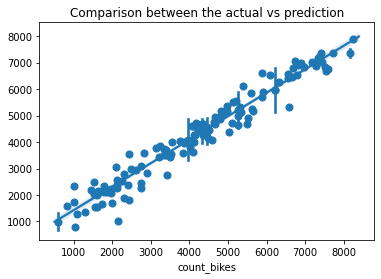

In [ ]:
## Performance of the prediction model

# 'count' variables for test data is predicted with the chosen model and parameters

clf = GradientBoostingRegressor(max_features= 2, min_samples_leaf= 5, min_samples_split= 20, n_estimators= 50)
clf.fit(x_train,y_train)
y_pred = clf.predict(x_test)

# A regression plot can be drawn between actual and predicted data to understand the performance of the model
# Bins are used to make the pattern more meaningful

ax = sns.regplot(y_test,y_pred,x_bins = 200)
ax.set(title = "Comparison between the actual vs prediction")

In [ ]:
y_pred_test_gb = clf.predict(x_test)
y_pred_train_gb = clf.predict(x_train)

In [ ]:
gb_metricas = metricas(y_test, y_train, y_pred_test_gb, y_pred_train_gb, "Gradient Boosting")
gb_metricas

,MAE,MSE,RMSE,R2,set,modelo
0,382.814442,223308.654447,472.555451,0.940993,test,Gradient Boosting
1,277.287860,130501.423320,361.249807,0.964859,train,Gradient Boosting


In [ ]:
gb_metricas.to_csv('metricas_gb_casual_registered.csv')

# XG BOOST

In [ ]:
#XGBoost hyper-parameter tuning
def hyperParameterTuning(X_train, y_train):
    param_tuning = {
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5, 7, 10],
        'min_child_weight': [1, 3, 5],
        'subsample': [0.5, 0.7],
        'colsample_bytree': [0.5, 0.7],
        'n_estimators' : [100, 200, 500],
        'objective': ['reg:squarederror']
    }

    xgb_model = XGBRegressor()

    gsearch = GridSearchCV(estimator = xgb_model,
                           param_grid = param_tuning,                        
                           #scoring = 'neg_mean_absolute_error', #MAE
                           #scoring = 'neg_mean_squared_error',  #MSE
                           cv = 5,
                           n_jobs = -1,
                           verbose = 1)

    gsearch.fit(X_train,y_train)

    return gsearch.best_params_

In [ ]:
hyperParameterTuning(x_train, y_train)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


{'colsample_bytree': 0.7,
 'learning_rate': 0.01,
 'max_depth': 10,
 'min_child_weight': 1,
 'n_estimators': 500,
 'objective': 'reg:squarederror',
 'subsample': 0.5}

In [ ]:
xgb_r = xg.XGBRegressor(colsample_bytree= 0.7,
 learning_rate= 0.01,
 max_depth= 10,
 min_child_weight= 1,
 n_estimators= 500,
 objective= 'reg:squarederror',
 subsample= 0.5)

In [ ]:
xgb_r.fit(x_train, y_train)

XGBRegressor(colsample_bytree=0.7, learning_rate=0.01, max_depth=10,
             n_estimators=500, objective='reg:squarederror', subsample=0.5)

In [ ]:
pred_train = xgb_r.predict(x_train)
pred_test = xgb_r.predict(x_test)

In [ ]:
xg_metricas = metricas(y_test, y_train, pred_test, pred_train, "XG Boosting")
xg_metricas

,MAE,MSE,RMSE,R2,set,modelo
0,324.392649,196910.892124,443.746428,0.949135,test,XG Boosting
1,119.802760,32823.894347,181.173658,0.991151,train,XG Boosting


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


[Text(0.5, 1.0, 'Comparison between the actual vs prediction')]

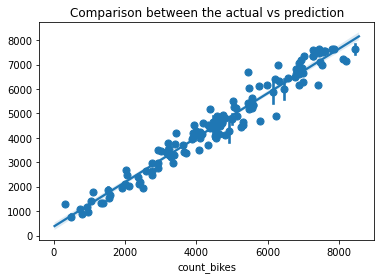

In [ ]:
y_pred = xgb_r.predict(x_test)
ax = sns.regplot(y_test,y_pred,x_bins = 200)
ax.set(title = "Comparison between the actual vs prediction")

In [ ]:
importancia_predictores = pd.DataFrame(
                            {'predictor': x_train.columns,
                             'importancia': xgb_r.feature_importances_}
                            )


# ordenamos de mayor a menor los resultados
importancia_predictores.sort_values(by=["importancia"], ascending=False, inplace = True)

# printeamos los resultados
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores

Importancia de los predictores en el modelo
-------------------------------------------


,predictor,importancia
8,registered_es,0.385638
0,year,0.380139
6,temp_es,0.076452
1,month,0.065361
2,weathersit,0.036471
5,laborables,0.019004
3,holiday,0.016144
7,windspeed_es,0.014459
4,dia_semana,0.006332


# AJUSTE DEL MODELO

In [ ]:
X2 = count.drop(["dteday", 'count_bikes', 'holiday','instant', 'dia_semana', 'windspeed_es', 'holiday', 'casual_es', 'laborables'], axis = 1)
y2 = count["count_bikes"]

In [ ]:
x_train2, x_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size = 0.2)

In [ ]:
hyperParameterTuning(x_train2, y_train2)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


{'colsample_bytree': 0.7,
 'learning_rate': 0.01,
 'max_depth': 5,
 'min_child_weight': 1,
 'n_estimators': 500,
 'objective': 'reg:squarederror',
 'subsample': 0.5}

In [ ]:
xgb_r = xg.XGBRegressor(colsample_bytree= 0.7,
 learning_rate= 0.01,
 max_depth= 3,
 min_child_weight= 1,
 n_estimators= 500,
 objective= 'reg:squarederror',
 subsample= 0.5)

In [ ]:
xgb_r.fit(x_train2, y_train2)

XGBRegressor(colsample_bytree=0.7, learning_rate=0.01, n_estimators=500,
             objective='reg:squarederror', subsample=0.5)

In [ ]:
pred_train2 = xgb_r.predict(x_train2)
pred_test2 = xgb_r.predict(x_test2)

In [ ]:
xg_metricas2 = metricas(y_test2, y_train2, pred_test2, pred_train2, "XG Boosting_R")
xg_metricas2

,MAE,MSE,RMSE,R2,set,modelo
0,342.099711,226198.093518,475.602874,0.931054,test,XG Boosting_R
1,295.790447,171773.740972,414.455958,0.955412,train,XG Boosting_R


In [ ]:
xg_metricas2.to_csv('metricas_r.csv')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


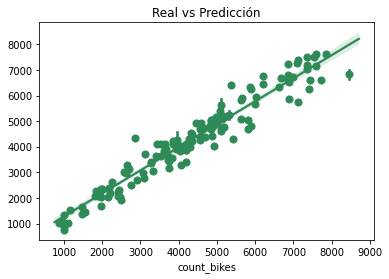

In [ ]:
y_pred2 = xgb_r.predict(x_test2)
ax = sns.regplot(y_test2,y_pred2,x_bins = 200, color='seagreen')
ax.set(title = "Real vs Predicción")
plt.savefig('real_predict_r.jpeg')

In [ ]:
importancia_predictores = pd.DataFrame(
                            {'predictor': x_train2.columns,
                             'importancia': xgb_r.feature_importances_}
                            )


# ordenamos de mayor a menor los resultados
importancia_predictores.sort_values(by=["importancia"], ascending=False, inplace = True)

# printeamos los resultados
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores

Importancia de los predictores en el modelo
-------------------------------------------


,predictor,importancia
0,year,0.339807
4,registered_es,0.337993
3,temp_es,0.187695
1,month,0.077752
2,weathersit,0.056752


# PREDICCIONES

In [ ]:
usuario = {'year': 1, 'month': 1, 'weathersit':2, 'temp_es': -0.82, 'registered_es': -1.92}

In [ ]:
df_usuario = pd.DataFrame(usuario, index = [0])
df_usuario

,year,month,weathersit,temp_es,registered_es
0,1,1,2,-0.82,-1.92


In [ ]:
y_usuario = xgb_r.predict(df_usuario)

In [ ]:
y_usuario

array([966.1351], dtype=float32)

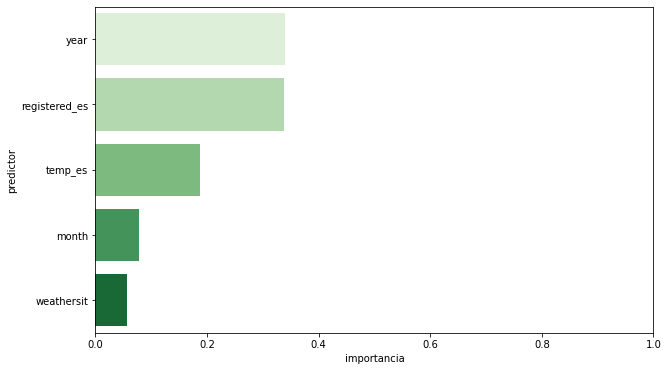

In [ ]:
plt.figure(figsize=(10,6))
sns.barplot(x = "importancia", y = "predictor", data = importancia_predictores, palette="Greens")
plt.xlim(0, 1);
plt.savefig('metricas_modelo_r.jpeg')
plt.show()
